## REINFORCE CARTPOLE KERAS using TAPE

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

import sys
sys.stderr = open('err.txt', 'w')

import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
MAX_EPISODES = 1000
ROLLING_WINDOW = 40
solved_threshold = 195

In [4]:


class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.98
        self.learning_rate = 0.001  # Increased learning rate
        self.hidden1, self.hidden2 = 48, 48

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_reinforce.h5")

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden1, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.hidden2, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.summary()
        
        # Don't compile here - we'll use custom training
        return model

    # Custom policy gradient loss function
    def policy_gradient_loss(self, y_true, y_pred):
        # y_true contains the advantages for each action
        # y_pred contains the action probabilities
        
        # Clip predictions to prevent log(0)
        y_pred_clipped = tf.clip_by_value(y_pred, 1e-8, 1.0)
        
        # Compute log probabilities
        log_probs = tf.math.log(y_pred_clipped)
        
        # Policy gradient loss: -sum(advantage * log(prob))
        loss = -tf.reduce_sum(y_true * log_probs, axis=1)
        
        return tf.reduce_mean(loss)

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.model.predict(state, batch_size=1, verbose=0).flatten()
        policy = policy / np.sum(policy)  # Normalize to ensure sum = 1
        
        # Add small epsilon to prevent issues with zero probabilities
        policy = np.clip(policy, 1e-8, 1.0)
        policy = policy / np.sum(policy)
        
        action = np.random.choice(self.action_size, 1, p=policy)[0]
        return action

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        episode_length = len(self.states)
        
        if episode_length == 0:
            return

        # Convert to numpy arrays
        states = np.array(self.states, dtype=np.float32)
        actions = np.array(self.actions)
        rewards = np.array(self.rewards, dtype=np.float32)

        # Calculate discounted rewards (returns)
        discounted_rewards = self.discount_rewards(rewards)
        
        # Normalize advantages (optional but often helps)
        if np.std(discounted_rewards) > 0:
            discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-8)

        # Create advantage array
        advantages = np.zeros((episode_length, self.action_size), dtype=np.float32)
        for i in range(episode_length):
            advantages[i][actions[i]] = discounted_rewards[i]

        # Custom training step using GradientTape
        optimizer = Adam(learning_rate=self.learning_rate)
        
        with tf.GradientTape() as tape:
            # Get action probabilities
            action_probs = self.model(states, training=True)
            
            # Calculate policy gradient loss
            loss = self.policy_gradient_loss(advantages, action_probs)

        # Calculate gradients and apply them
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Clip gradients to prevent exploding gradients
        gradients = [tf.clip_by_norm(grad, 1.0) if grad is not None else grad for grad in gradients]
        
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Clear episode data
        self.states, self.actions, self.rewards = [], [], []
        
        return loss.numpy()



In [5]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = REINFORCEAgent(state_size, action_size)

episode_rewards, rolling_avg = [], []

for episode in range(MAX_EPISODES):
    state,_ = env.reset()
    if isinstance(state, tuple):  # Handle new gym versions
        state = state[0]
    
    score = 0
    done = False
    step = 0
    
    while not done:
        step = step + 1
        if agent.render:
            env.render()
            
        state = np.reshape(state, [1, state_size])
        action = agent.get_action(state)
        
        next_state, reward, done, truncated, _ = env.step(action)
        if isinstance(next_state, tuple):
            next_state = next_state[0]
            
        # You might want to modify the reward signal
        # reward = reward if not done else -10
        
        agent.append_sample(state[0], action, reward)
        score += reward
        state = next_state
                
        if done or truncated:
            break
    
    # Train the model after each episode
    loss = agent.train_model()

    # Print progress
    episode_rewards.append(score)
    rolling_avg.append(np.mean(episode_rewards[-ROLLING_WINDOW:]))
    
    # break if score
    avg_score = np.mean(episode_rewards[-ROLLING_WINDOW:])
    if avg_score > 195:
        break
    
    print(f"Episode: {episode+1:3}/{MAX_EPISODES}, Reward: {score:+7.2f}, "
              f"Rolling Avg: {avg_score:6.2f}, Steps: {step:3} Terminated: {done} Loss: {loss:7.4f}")
               
env.close()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            98 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,690 (10.51 KB)

 Trainable params: 2,690 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

Episode:   1/1000, Reward:  +19.00, Rolling Avg:  19.00, Steps:  19 Terminated: True Loss: -0.0050
Episode:   2/1000, Reward:  +10.00, Rolling Avg:  14.50, Steps:  10 Terminated: True Loss: -0.0293
Episode:   3/1000, Reward:  +15.00, Rolling Avg:  14.67, Steps:  15 Terminated: True Loss:  0.0137
Episode:   4/1000, Reward:  +21.00, Rolling Avg:  16.25, Steps:  21 Terminated: True Loss:  0.0025
Episode:   5/1000, Reward:  +68.00, Rolling Avg:  26.60, Steps:  68 Terminated: True Loss:  0.0111
Episode:   6/1000, Reward:  +24.00, Rolling Avg:  26.17, Steps:  24 Terminated: True Loss:  0.0050
Episode:   7/1000, Reward:  +20.00, Rolling Avg:  25.29, Steps:  20 Terminated: True Loss: -0.0086
Episode:   8/1000, Reward:  +16.00, Rolling Avg:  24.12, Steps:  16 Terminated: True Loss: -0.0014
Episode:   9/1000, Reward:  +12.00, Rolling Avg:  22.78, Steps:  12 Terminated: True Loss: -0.0119
Episode:  10/1000, Reward:  +72.00, Rolling Avg:  27.70, Steps:  72 Terminated: True Loss:  0.0030
Episode:  

Episode:  84/1000, Reward:  +44.00, Rolling Avg:  31.57, Steps:  44 Terminated: True Loss:  0.0246
Episode:  85/1000, Reward:  +20.00, Rolling Avg:  31.57, Steps:  20 Terminated: True Loss:  0.0406
Episode:  86/1000, Reward:  +67.00, Rolling Avg:  32.92, Steps:  67 Terminated: True Loss: -0.0034
Episode:  87/1000, Reward:  +58.00, Rolling Avg:  33.17, Steps:  58 Terminated: True Loss: -0.0155
Episode:  88/1000, Reward:  +19.00, Rolling Avg:  32.73, Steps:  19 Terminated: True Loss: -0.0700
Episode:  89/1000, Reward:  +45.00, Rolling Avg:  32.60, Steps:  45 Terminated: True Loss:  0.0257
Episode:  90/1000, Reward:  +41.00, Rolling Avg:  32.77, Steps:  41 Terminated: True Loss:  0.0163
Episode:  91/1000, Reward:  +67.00, Rolling Avg:  34.10, Steps:  67 Terminated: True Loss: -0.0203
Episode:  92/1000, Reward:  +41.00, Rolling Avg:  34.48, Steps:  41 Terminated: True Loss: -0.0307
Episode:  93/1000, Reward:  +86.00, Rolling Avg:  36.12, Steps:  86 Terminated: True Loss: -0.0220
Episode:  

Episode: 167/1000, Reward:  +28.00, Rolling Avg:  73.35, Steps:  28 Terminated: True Loss: -0.0111
Episode: 168/1000, Reward: +110.00, Rolling Avg:  73.75, Steps: 110 Terminated: True Loss:  0.0077
Episode: 169/1000, Reward:  +26.00, Rolling Avg:  73.53, Steps:  26 Terminated: True Loss: -0.0651
Episode: 170/1000, Reward:  +34.00, Rolling Avg:  73.97, Steps:  34 Terminated: True Loss: -0.0164
Episode: 171/1000, Reward:  +41.00, Rolling Avg:  74.05, Steps:  41 Terminated: True Loss: -0.0957
Episode: 172/1000, Reward:  +94.00, Rolling Avg:  74.97, Steps:  94 Terminated: True Loss: -0.0525
Episode: 173/1000, Reward:  +90.00, Rolling Avg:  73.83, Steps:  90 Terminated: True Loss: -0.0378
Episode: 174/1000, Reward:  +18.00, Rolling Avg:  72.38, Steps:  18 Terminated: True Loss:  0.0502
Episode: 175/1000, Reward: +123.00, Rolling Avg:  72.90, Steps: 123 Terminated: True Loss: -0.0084
Episode: 176/1000, Reward:  +63.00, Rolling Avg:  71.47, Steps:  63 Terminated: True Loss: -0.0646
Episode: 1

Episode: 250/1000, Reward: +124.00, Rolling Avg: 166.25, Steps: 124 Terminated: True Loss: -0.0699
Episode: 251/1000, Reward: +218.00, Rolling Avg: 167.10, Steps: 218 Terminated: True Loss:  0.0236
Episode: 252/1000, Reward: +228.00, Rolling Avg: 172.20, Steps: 228 Terminated: True Loss:  0.0039
Episode: 253/1000, Reward: +326.00, Rolling Avg: 178.07, Steps: 326 Terminated: True Loss: -0.0127
Episode: 254/1000, Reward: +150.00, Rolling Avg: 179.82, Steps: 150 Terminated: True Loss: -0.0326
Episode: 255/1000, Reward: +222.00, Rolling Avg: 181.80, Steps: 222 Terminated: True Loss: -0.0177
Episode: 256/1000, Reward: +126.00, Rolling Avg: 181.12, Steps: 126 Terminated: True Loss:  0.0071
Episode: 257/1000, Reward: +199.00, Rolling Avg: 179.95, Steps: 199 Terminated: True Loss: -0.0029
Episode: 258/1000, Reward: +172.00, Rolling Avg: 180.12, Steps: 172 Terminated: True Loss: -0.0137
Episode: 259/1000, Reward: +107.00, Rolling Avg: 179.95, Steps: 107 Terminated: True Loss: -0.0631
Episode: 2

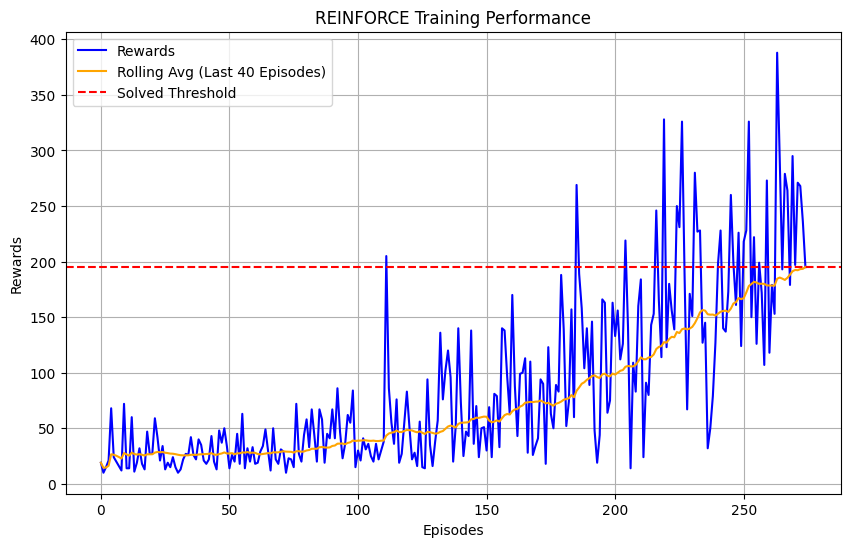

In [6]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg, label='Rolling Avg (Last '+str(ROLLING_WINDOW)+' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('REINFORCE Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Using Policy to select next action

# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        
        action = agent.get_action(state)                  # We use the policy to get the next action

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode: 1/10, Reward: 113.00, Steps: 113
Test Episode: 2/10, Reward: 193.00, Steps: 193
Test Episode: 3/10, Reward: 284.00, Steps: 284
Test Episode: 4/10, Reward: 145.00, Steps: 145
Test Episode: 5/10, Reward: 400.00, Steps: 400
Test Episode: 6/10, Reward: 204.00, Steps: 204
Test Episode: 7/10, Reward: 292.00, Steps: 292
Test Episode: 8/10, Reward: 148.00, Steps: 148
Test Episode: 9/10, Reward: 142.00, Steps: 142
Test Episode: 10/10, Reward: 212.00, Steps: 212
Testing completed in 1.41 minutes


In [13]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    
    action = agent.get_action(state)                  # We use the policy to get the next action

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_REINFORCE.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_REINFORCE.gif')


Rendered Test Episode Reward: 143.00
Saved GIF to: ./CARTPOLE_REINFORCE.gif


In [14]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.19.0
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-06-10 10:23
